In [145]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from particle import Particle, InvalidParticle, ParticleNotFound

# Initial FASERvSi studies

Detector setup:
132 layers of Tungsten and 'SCT' (sensitive vacuum)
Tungsten layers are 0.9 mm thick
Gap between Tungsten sheets is 0.5 mm
1000 events generated - mix of $\nu_e$, $\nu_\mu$ and $\nu_\tau$

Real gap *should* be 7.08 mm but there seems to be an issue with the GENIE code which is preventing neutrinos from being generated in that setup

In [165]:
data = uproot.open("../FASERvSi_baseline-build/output.root")

In [200]:
def _get_pos_and_energy(uproot_data, particle_type, event_number=None):
    allowed_types = ["ep", "em", "mm",  "mp", "hm", "hp"]
    if particle_type not in allowed_types:
        raise ValueError(f"particle_type must be one of these {allowed_types}")

    kin_suffixes = ["x", "y", "z", "E"]
    
    cut_expression = f"{particle_type}_z >= 0" 
    
    kinematics = uproot_data.arrays([f"{particle_type}_{k}" for k in kin_suffixes], library="np", cut=cut_expression)
    
    if event_number is None:
        return {"x": kinematics[f"{particle_type}_x"], "y": kinematics[f"{particle_type}_y"], "z": kinematics[f"{particle_type}_z"], "E": kinematics[f"{particle_type}_E"]}
    
    return {"x": kinematics[f"{particle_type}_x"][event_number], "y": kinematics[f"{particle_type}_y"][event_number], "z": kinematics[f"{particle_type}_z"][event_number], "E": kinematics[f"{particle_type}_E"][event_number]}
    

In [201]:
def _get_name_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(pdgc)
        
        particle_name = particle.name
        
        if pdgc < 0 and "+" not in particle_name and "-" not in particle_name:
            particle_name = f"anti-{particle_name}"
        
        return particle_name
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"

In [205]:
def _get_charge_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(pdgc)
        
        particle_charge = particle.charge
        
        return particle_charge
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"

In [206]:
def get_name_from_pdgc(pdgc):
    result = []
    try:
        len(pdgc)
        for p in pdgc:
            result.append(_get_name_from_pdgc(p))
    except TypeError:
        return _get_name_from_pdgc(pdgc)

    return np.array(result)

In [207]:
def get_charge_from_pdgc(pdgc):
    result = []
    try:
        len(pdgc)
        for p in pdgc:
            result.append(_get_charge_from_pdgc(p))
    except TypeError:
        return _get_name_from_pdgc(pdgc)
    
    return np.array(result)

In [166]:
hits = [data[treename] for treename in data.keys()]

In [208]:
pdgc = hits[-1].arrays("pdgc", library="np")["pdgc"]

pdgc = set(pdgc)

for p in pdgc:
    print(f"pdgc = {p:<13}    name = {get_name_from_pdgc(p):<13}    charge = {get_charge_from_pdgc(p)}")

pdgc = 130.0            name = K(L)0            charge = K(L)0
pdgc = 11.0             name = e-               charge = e-
pdgc = 12.0             name = nu(e)            charge = nu(e)
pdgc = 13.0             name = mu-              charge = mu-
pdgc = 14.0             name = nu(mu)           charge = nu(mu)
pdgc = 16.0             name = nu(tau)          charge = nu(tau)
pdgc = 22.0             name = gamma            charge = gamma
pdgc = 4122.0           name = Lambda(c)+       charge = Lambda(c)+
pdgc = 2212.0           name = p                charge = p
pdgc = 1000010020.0     name = D2               charge = D2
pdgc = 3112.0           name = Sigma-           charge = Sigma-
pdgc = -211.0           name = pi-              charge = pi-
pdgc = 1000010030.0     name = T3               charge = T3
pdgc = 3122.0           name = Lambda           charge = Lambda
pdgc = 310.0            name = K(S)0            charge = K(S)0
pdgc = -321.0           name = K-               charge = K-
pd

In [150]:
def scatter_on_ax(ax, event_data, x_var, y_var, label, color,  alpha=1, marker_size=1):
    
    if len(event_data[x_var]) == 0:
        return None
    
    ax.scatter(event_data[x_var], event_data[y_var], color=color, marker=",", label=label, alpha=alpha, s=marker_size)

In [167]:
event_numbers = hits[0].arrays("fEvent", library="np")["fEvent"]

print(event_numbers)

[ 0  3  9 10 10 10 10 14 14 14 14 15 17 18 20 22 26 26 26 26 26 30 33 33
 33 33 35 35 39 39 42 45 45 45 47 47 47 47 47 47 49 51 55 55 57 57 59 59
 60 61 65 66 69 71 73 75 80 81 81 81 81 81 81 85 85 85 85 85 85 85 88 88
 88 90 94 96]


  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:29<01:57,  2.93s/it]


KeyboardInterrupt: 

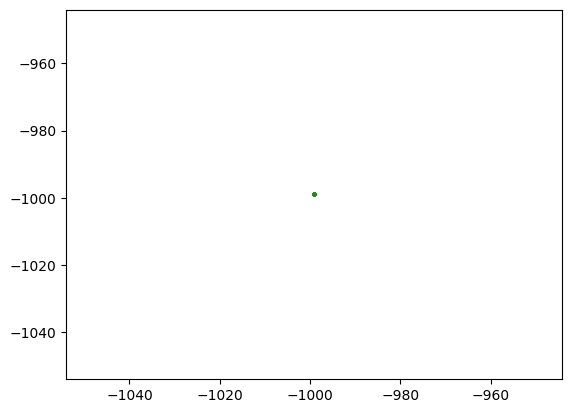

In [217]:
for i in tqdm(range(0, 100)):
    
    fig, ax = plt.subplots()

    for s, station in enumerate(hits):
        
        kinematics = station.arrays(station.keys(), library="ak", cut=f"fEvent == {i}")
        
        marker_size = 1
        alpha = 1
        
        electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]
        
        if len(taus["E"] != 0):
            print(taus["E"])
        
        gluons = kinematics[np.where(np.abs(kinematics['pdgc']) == 21)]
        photons = kinematics[np.where(np.abs(kinematics['pdgc']) == 22)]
        charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        neutral_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        neutral_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) == 0)]
        
        scatter_on_ax(ax, neutral_hadrons, "z", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax, charged_hadrons, "z", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax, photons, "z", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax, gluons, "z", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax, electrons, "z", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax, muons, "z", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax, taus, "z", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)
        
        
        
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncols=2, loc='center right', bbox_to_anchor=(1.55, 0.75))
    ax.set_xlabel("z position (mm)")
    ax.set_ylabel("y position (mm)")
    ax.set_xlim((550, 735))
    ax.set_ylim((-150, 150))
    plt.savefig(f"eventPlots/FASERvSi-0.5mmSCT/event_{i}_particle-dist-z-y.png", dpi=300, bbox_inches='tight')
    plt.close()
    # break
        

In [219]:
for i in tqdm(range(0, 100)):

    for s, station in enumerate(hits):
        
        kinematics = station.arrays(station.keys(), library="ak", cut=f"fEvent == {i}")
        
        marker_size = 1
        alpha = 1
        
        # electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        # muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]
        
        if len(taus["E"] != 0):
            print(taus["E"])
        
        # gluons = kinematics[np.where(np.abs(kinematics['pdgc']) == 21)]
        # photons = kinematics[np.where(np.abs(kinematics['pdgc']) == 22)]
        # charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        # neutral_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        # charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        # neutral_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) == 0)]


 14%|█▍        | 14/100 [00:08<00:56,  1.52it/s]

[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]
[933]


 88%|████████▊ | 88/100 [01:00<00:07,  1.59it/s]

[1.91e+03]
[1.91e+03]
[1.91e+03]
[1.91e+03]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]
